In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random

from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# import the data (chunksize returns jsonReader for iteration)
businesses = pd.read_json("yelp_academic_dataset_business.json", lines=True, orient='columns', chunksize=200000)
reviews = pd.read_json("yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=500000)

In [3]:
# read the data
for business in businesses:
    business_chunk = business
    break

for review in reviews:
    review_chunk = review
    break

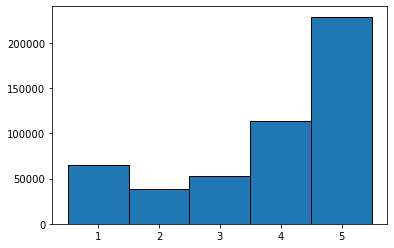

In [5]:
plt.hist(review_chunk['stars'], range=(0.5,5.5), bins=5, edgecolor="black")
plt.show()

In [5]:
len(review_chunk[review_chunk['stars']==2])

38856

In [7]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.4 MB/s eta 0:00:00


In [18]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

nltk.download('omw-1.4')

lem = WordNetLemmatizer()

string = "I'm thinking that Computer Science couldn't can be dope!"



words = word_tokenize(re.sub(r"[^\w\s]", "", string))

for w in words:
    print(w, " : ", lem.lemmatize(w))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/timcrawley/nltk_data...


Im  :  Im
thinking  :  thinking
that  :  that
Computer  :  Computer
Science  :  Science
couldnt  :  couldnt
can  :  can
be  :  be
dope  :  dope


In [6]:
# To create a df of reviews of Restaurants
restaurants = business_chunk[business['categories'].str.contains('Restaurant') == True]
df = review_chunk[review_chunk.business_id.isin(restaurants['business_id']) == True]

In [7]:
df.shape

(346460, 9)

In [19]:
def clean_and_tokenize(string):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word) for word in word_tokenize(re.sub(r"[^\w\s]", "", string))]

In [20]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [44]:
len(df[df['useful']==0]),  len(df[df['stars']==1]), len(df[df['stars']==5])

(211369, 38468, 148360)

In [24]:
df_data = df.copy().drop(columns=["review_id", "user_id", "business_id", "useful", "funny", "cool", "date"])

In [25]:
df_data.head()

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
5,1,I am a long term frequent customer of this est...


In [26]:
df_data["cleaned_tokens"] = df_data["text"].apply(clean_and_tokenize)

In [27]:
df_data.head()

,stars,text,cleaned_tokens
0,3,"If you decide to eat here, just be aware it is...","[If, you, decide, to, eat, here, just, be, awa..."
2,3,Family diner. Had the buffet. Eclectic assortm...,"[Family, diner, Had, the, buffet, Eclectic, as..."
3,5,"Wow! Yummy, different, delicious. Our favo...","[Wow, Yummy, different, delicious, Our, favori..."
4,4,Cute interior and owner (?) gave us tour of up...,"[Cute, interior, and, owner, gave, u, tour, of..."
5,1,I am a long term frequent customer of this est...,"[I, am, a, long, term, frequent, customer, of,..."


In [29]:
df_data['cleaned_tokens'] = df_data['cleaned_tokens'].apply(lambda x: " ".join(x))

In [30]:
df_data.head()

,stars,text,cleaned_tokens
0,3,"If you decide to eat here, just be aware it is...",If you decide to eat here just be aware it is ...
2,3,Family diner. Had the buffet. Eclectic assortm...,Family diner Had the buffet Eclectic assortmen...
3,5,"Wow! Yummy, different, delicious. Our favo...",Wow Yummy different delicious Our favorite is ...
4,4,Cute interior and owner (?) gave us tour of up...,Cute interior and owner gave u tour of upcomin...
5,1,I am a long term frequent customer of this est...,I am a long term frequent customer of this est...


In [32]:
X, y = df_data['cleaned_tokens'], df_data['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
vectorizer = CountVectorizer()
X_train_vector_data = vectorizer.fit_transform(X_train)
X_test_vector_data = vectorizer.transform(X_test)

In [34]:
mnb = MultinomialNB()
mnb.fit(X_train_vector_data, y_train)

MultinomialNB()

In [35]:
y_pred = mnb.predict(X_test_vector_data)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6228280320960573

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.73      0.67      7738
           2       0.40      0.25      0.31      6023
           3       0.43      0.35      0.39      8276
           4       0.51      0.49      0.50     17650
           5       0.75      0.83      0.79     29605

    accuracy                           0.62     69292
   macro avg       0.54      0.53      0.53     69292
weighted avg       0.60      0.62      0.61     69292



Other features to be explored:

 * Time of day
 * Length of message
 * Frequency of keyword lists

In [8]:
!pip install seaborn